## Hackathon

In [87]:
import xarray as xr
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.pyplot as plt

xr.set_options(display_style="text")

## Data loader om data uit de grote set te halen.

Gebruik `loader.get_subset()` voor specifieke ranges van tijd, longitude en latitude. 

Gebruik `subset.to_dataframe()` om een tabel van type xarray om te zetten naar een pandas dataframe. 

In [88]:
class DataLoader:
    """Simple dataloader for NetCDF temperature data."""
    
    def __init__(self, file_path):
        self.file_path = file_path
        self.dataset = None
    
    def load_data(self):
        """Load and preprocess the dataset."""
        self.dataset = xr.open_dataset(self.file_path, engine="h5netcdf")
        
        # Fix coordinates
        if self.dataset["longitude"].max() > 180:
            self.dataset = self.dataset.assign_coords(
                longitude=(self.dataset["longitude"].values + 180) % 360 - 180
            )
        if self.dataset["latitude"].max() > 90:
            self.dataset = self.dataset.assign_coords(
                latitude=self.dataset["latitude"].values - 90
            )
        
        # Sort coordinates
        self.dataset = self.dataset.sortby(["latitude", "longitude"])
        return self.dataset
    
    def get_subset(self, time_range=None, lat_range=None, lon_range=None):
        """Get a subset of the data."""
        if self.dataset is None:
            raise ValueError("Load data first!")
        
        subset = self.dataset
        if time_range:
            subset = subset.sel(valid_time=slice(time_range[0], time_range[1]))
        if lat_range:
            subset = subset.sel(latitude=slice(lat_range[0], lat_range[1]))
        if lon_range:
            subset = subset.sel(longitude=slice(lon_range[0], lon_range[1]))
        
        return subset.compute()
    


In [89]:
# Example usage
loader = DataLoader("2023_2m_temperature.nc")
dataset = loader.load_data()

In [90]:
print(dataset['longitude'].min().item())
print(dataset['longitude'].max().item())
print(dataset['latitude'].min().item())
print(dataset['latitude'].max().item())


-25.0
37.25
34.0
71.25


In [91]:
# Get a subset (May 2023, Europe)
subset = loader.get_subset(
    time_range=("2023-01-01", "2023-12-31"),
    lat_range=(52.25, 52.25),
    lon_range=(5.0, 5.0)
)
subset

min_time = dataset.valid_time.min().values
max_time = dataset.valid_time.max().values

min_lon = dataset.longitude.min().values
max_lon = dataset.longitude.max().values
min_lat = dataset.latitude.min().values
max_lat = dataset.latitude.max().values

print("Min time:", min_time)
print("Max time:", max_time)

print("Min lon:", min_lon)
print("Max lon:", max_lon)
print("Min lat:", min_lat)
print("Max lat:", max_lat)


Min time: 2023-01-01T00:00:00.000000000
Max time: 2023-12-31T23:00:00.000000000
Min lon: -25.0
Max lon: 37.25
Min lat: 34.0
Max lat: 71.25


In [92]:
subset["t2m"].data.flatten()[0:10]

array([287.72104, 287.52673, 287.25696, 286.77545, 285.91565, 285.18488,
       284.83664, 284.40027, 284.11185, 284.33044], dtype=float32)

In [93]:
subset_df = subset.to_dataframe().reset_index()
subset_df = subset_df.drop(['number', 'expver'], axis=1)
subset.to_dataframe()

mean_t2m = dataset['t2m'].sel(valid_time=slice("2023-05-01", "2023-05-31")).mean(dim='valid_time')

mean_t2m.head(10)


<xarray.DataArray 't2m' (latitude: 10, longitude: 10)> Size: 400B
array([[292.36533, 292.37976, 292.39536, 292.40985, 292.42346, 292.4164 ,
        292.4073 , 292.39465, 292.3907 , 292.3938 ],
       [292.29376, 292.29395, 292.302  , 292.3161 , 292.32867, 292.32608,
        292.3199 , 292.31174, 292.3013 , 292.2936 ],
       [292.2234 , 292.21774, 292.21832, 292.2219 , 292.22504, 292.23254,
        292.23364, 292.22736, 292.21704, 292.20502],
       [292.1427 , 292.14313, 292.14307, 292.14307, 292.14542, 292.14932,
        292.15042, 292.1447 , 292.1306 , 292.11514],
       [292.0662 , 292.07605, 292.07547, 292.0718 , 292.0739 , 292.06815,
        292.07257, 292.0755 , 292.06693, 292.03418],
       [292.0012 , 292.01117, 292.01672, 292.02026, 292.02765, 292.0151 ,
        292.00876, 292.00513, 292.0052 , 291.97565],
       [291.91922, 291.93338, 291.94107, 291.94635, 291.9487 , 291.9458 ,
        291.94055, 291.9346 , 291.92346, 291.89096],
       [291.8059 , 291.81635, 291.832  , 291.84048, 291.84723, 291.8532 ,
        291.84906, 291.8478 , 291.8465 , 291.82336],
       [291.70346, 291.7078 , 291.7215 , 291.72714, 291.73465, 291.74356,
        291.75967, 291.76126, 291.77145, 291.75778],
       [291.6207 , 291.62198, 291.60944, 291.6152 , 291.6217 , 291.63513,
        291.65103, 291.67233, 291.68567, 291.6781 ]], dtype=float32)
Coordinates:
    number     int64 8B ...
  * latitude   (latitude) float64 80B 34.0 34.25 34.5 34.75 ... 35.75 36.0 36.25
  * longitude  (longitude) float64 80B -25.0 -24.75 -24.5 ... -23.0 -22.75

In [94]:
fig = px.line(subset_df, x='valid_time', y='t2m')
fig.show()    


In [95]:

print(subset_df.columns)

Index(['valid_time', 'latitude', 'longitude', 't2m'], dtype='object')


## Methode om je forecast functie te evalueren op een random steekproef van de dataset. 
In dit voorbeeld wordt steeds 2 weken historische data gepakt en wordt 1 week vooruit voorspeld.

`generate_eval_data()` geeft n random periodes van 3 weken op willekeurige locaties.

`forecast(history, n_points)` neemt een historische reeks van temperaturen en voorspelt de volgende n_points.

`forecast_1w()` evalueert de forecast functie op een random week (MAE score) en toont een grafiek van de historische reeks, de echte waardes en de voorspelde waarde. 

`evaluator(function, n_samples)` berekent de mean absolute error (MAE) van de voorspelling van functie `forecast()` voor een steekproef van grootte n_samples. 

In [96]:
def generate_eval_data(n = 100):
    rng = np.random.default_rng()
    
    # ---- Random geolocation ----
    # Longitude uniform in [-180, 180)
    lon = rng.uniform(-25, 37.25, n)
    lon = np.round(lon * 4)/4
    
    # Latitude area-uniform: sample z = sin(lat) ~ U(-1,1)  => lat = arcsin(z)
    lat = rng.uniform(34, 71.25, n)
    lat = np.round(lat * 4)/4
    
    # ---- Random 3-week interval in 2023 ----
    start0 = pd.Timestamp("2023-01-01")
    # Inclusive end = start + 20 days (21 calendar days total)
    last_start = pd.Timestamp("2023-12-31") - pd.Timedelta(days=20)
    num_choices = (last_start - start0).days + 1
    
    offsets = rng.integers(0, num_choices, n)  # days after Jan 1
    start_date = start0 + pd.to_timedelta(offsets, unit="D")
    end_date = start_date + pd.Timedelta(days=20)
    
    # ---- Assemble DataFrame ----
    df = pd.DataFrame({
        "latitude_deg": lat,
        "longitude_deg": lon,
        "start_date": start_date.strftime("%Y-%m-%d"),
        "end_date": end_date.strftime("%Y-%m-%d")
    })
    return df

In [97]:
generate_eval_data(5)

,latitude_deg,longitude_deg,start_date,end_date
0,50.00,25.25,2023-07-15,2023-08-04
1,55.75,-16.50,2023-02-13,2023-03-05
2,35.00,16.75,2023-04-07,2023-04-27
3,44.75,31.50,2023-09-23,2023-10-13
4,54.50,-22.25,2023-03-21,2023-04-10


In [98]:
def forecast(history, lon = 40, lat = 25, start_date_hist = '2023-02-23', end_date_hist = '2023-03-08', n_points = 7*24):
    # Take the last point of the history and repeat it n_points times
    try:
        return np.full(n_points, history[-1])
    except: 
        return np.full(n_points, 0)

def forecast_1w(row, function, operation = 'loop'):
    sample = loader.get_subset(
            time_range=(row['start_date'], row['end_date']),
            lat_range=(row['latitude_deg'], row['latitude_deg']),
            lon_range=(row['longitude_deg'], row['longitude_deg'])
        ).compute()
    history = sample.sel(valid_time=slice(row['start_date'],(pd.to_datetime(row['start_date']) + pd.Timedelta(weeks=2)).strftime("%Y-%m-%d")))['t2m'].data.flatten()
    y_true = sample.sel(valid_time=slice((pd.to_datetime(row['start_date']) + pd.Timedelta(weeks=2)).strftime("%Y-%m-%d"),row['end_date']))['t2m'].data.flatten()
    y_pred = function(history, 
                      row['longitude_deg'], 
                      row['latitude_deg'], 
                      row['start_date'],
                      (pd.to_datetime(row['start_date']) + pd.Timedelta(weeks=2)).strftime("%Y-%m-%d"), 
                      len(y_true))
    if operation == 'manual':
        fig, ax = plt.subplots()
        ax.plot(range(len(history)), history, color = 'blue')
        ax.plot(range(len(history), len(history) + len(y_true)), y_true, color = 'blue', linestyle = 'dashed')
        ax.plot(range(len(history), len(history) + len(y_true)), y_pred, color = 'green', linestyle = (0, (1, 1)))
    return np.mean(np.abs(y_true - y_pred))

In [99]:
forecast(np.array([9,8,18]), n_points = 5)

array([18, 18, 18, 18, 18])

np.float32(2.214274)

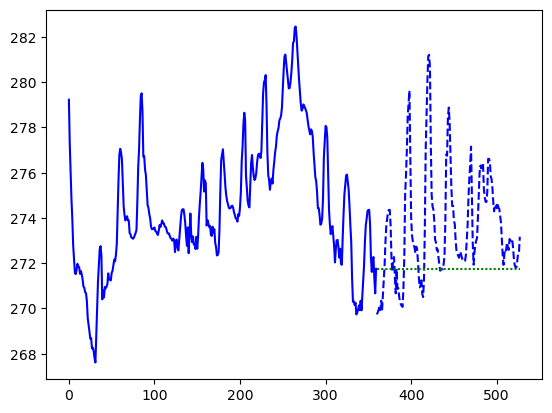

In [100]:
forecast_1w(generate_eval_data(1).iloc[0], forecast, 'manual')

In [101]:
def evaluator(function, n_samples = 100):
    errors = []
    df = generate_eval_data(n_samples)
    for index, row in df.iterrows():
        error = forecast_1w(row, function, operation = 'loop')
        errors.append(error)
    return np.mean(errors)

In [102]:
evaluator(forecast, 10)

np.float32(3.4355335)

In [103]:
print(type(mean_t2m))
mean_t2m

<class 'xarray.core.dataarray.DataArray'>


<xarray.DataArray 't2m' (latitude: 150, longitude: 250)> Size: 150kB
array([[292.36533, 292.37976, 292.39536, ..., 291.73257, 293.1246 ,
        293.91678],
       [292.29376, 292.29395, 292.302  , ..., 291.82297, 292.9372 ,
        293.60104],
       [292.2234 , 292.21774, 292.21832, ..., 292.84604, 293.561  ,
        293.9185 ],
       ...,
       [268.70557, 268.81747, 268.492  , ..., 277.88016, 277.86942,
        277.86008],
       [268.59415, 268.61346, 268.18356, ..., 277.79022, 277.76172,
        277.73187],
       [268.13318, 267.6679 , 267.19965, ..., 277.6286 , 277.59344,
        277.55865]], dtype=float32)
Coordinates:
    number     int64 8B ...
  * latitude   (latitude) float64 1kB 34.0 34.25 34.5 34.75 ... 70.75 71.0 71.25
  * longitude  (longitude) float64 2kB -25.0 -24.75 -24.5 ... 36.75 37.0 37.25

/var/folders/qb/p8lv123j4jb5rn109y_rxthw0000gn/T/ipykernel_13352/2917984960.py:46: UserWarning:

The GeoSeries you are attempting to plot is empty. Nothing has been displayed.



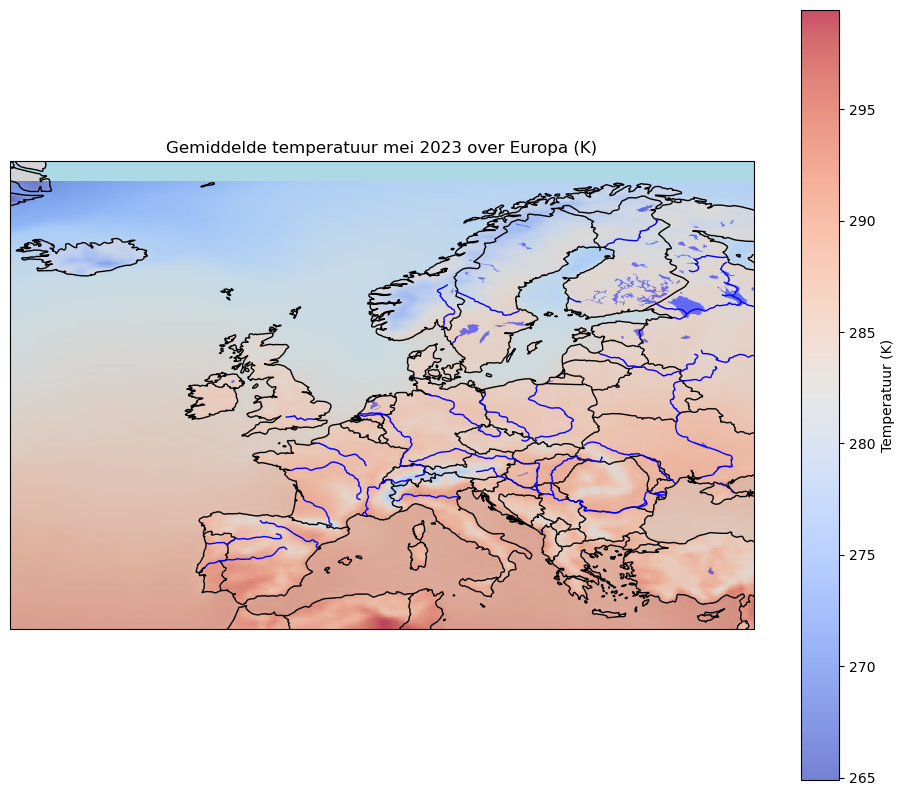

In [108]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import box
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# === 1. Shapefile inladen ===
geo_df = gpd.read_file('CNTR_RG_20M_2024_3035.shp')

# === 2. Bounding box voor Europa ===
lat_min, lat_max = 34, 73
lon_min, lon_max = -25, 37

bbox = gpd.GeoDataFrame(
    geometry=[box(lon_min, lat_min, lon_max, lat_max)],
    crs=geo_df.crs
)

# Snijd shapefile bij op bounding box
geo_df_clipped = gpd.overlay(geo_df, bbox, how='intersection')

# === 3. Rastergegevens van DataArray t2m ===
lats = mean_t2m.latitude.values
lons = mean_t2m.longitude.values
temps = mean_t2m.values  # al in Kelvin

# === 4. Plotten met Cartopy ===
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Zoom naar Europa
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Raster plotten
img = ax.imshow(
    temps,
    extent=(lons.min(), lons.max(), lats.min(), lats.max()),
    origin='lower',
    cmap='coolwarm',
    alpha=0.7,
    transform=ccrs.PlateCarree()
)
fig.colorbar(img, ax=ax, label='Temperatuur (K)')

# Europa grenzen uit shapefile
geo_df_clipped.boundary.plot(ax=ax, color='black', linewidth=1, transform=ccrs.PlateCarree())

# Cartopy features
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.BORDERS, edgecolor='black')
ax.add_feature(cfeature.LAKES, facecolor='blue', alpha=0.5)
ax.add_feature(cfeature.RIVERS, edgecolor='blue')
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=1)

# Titel
ax.set_title("Gemiddelde temperatuur mei 2023 over Europa (K)")

plt.show()
